In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage, print_forecasts_by_week,\
forecast_by_week, train_test_split,update_deepAR_parameters, hyperparameter_boxplots,\
generate_model_results_by_hp_dict, plot_model_results_by_hp, hp_color_plot
from PythonFiles.Configuration import Configuration
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset,StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
import itertools
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')
population_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/PopulationVector.csv", sep=',')
neighbourhood_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/AdjacentMatrix.csv", sep=',', index_col=0)

In [3]:
data_splits_dict = {}
output_dict = {}

locations = list(influenza_df.location.unique())
#Process the df into a uniformly spaced df
df = influenza_df.loc[influenza_df.location.isin(locations), ['value', 'location', 'date','week']]
df = preprocessing(config, df, check_count=False, output_type="corrected_df")
for location in locations:
    df.loc[df.location == location, "population"] = int(population_df.loc[population_df.Location == location, "2011"].values[0])
    df.loc[df.location == location, locations] = neighbourhood_df.loc[neighbourhood_df.index==location,locations].values[0].astype(int)

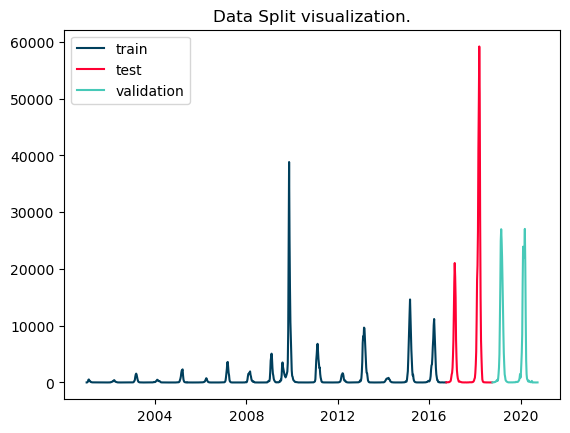

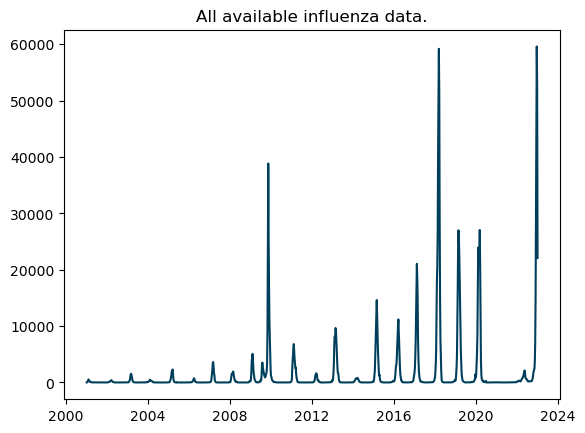

In [4]:
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
sum_df = pd.DataFrame()
sum_df.index = df.index.unique()
for date in df.index.unique():
    sum_df.loc[sum_df.index == date,'value'] = df.loc[df.index == date]['value'].sum()
plt.plot((sum_df.loc[(sum_df.index <= config.train_end_time)].index),
         sum_df.loc[(sum_df.index <= config.train_end_time),'value'], c=colors[0], label="train")

plt.plot((sum_df.loc[(sum_df.index <= config.test_end_time) & 
                 (sum_df.index > config.train_end_time)].index),
         sum_df.loc[(sum_df.index <= config.test_end_time) &
                (sum_df.index > config.train_end_time),'value'], c=colors[1], label="test")

plt.plot((sum_df.loc[(sum_df.index > config.test_end_time) & 
                 (sum_df.index <= config.validation_end_time)].index),
         sum_df.loc[(sum_df.index > config.test_end_time) &
                (sum_df.index <= config.validation_end_time),'value'], c=colors[2], label="validation")

plt.legend()
plt.title("Data Split visualization.")
plt.savefig("InfluenzaDataSplit.png")
plt.show()

plt.plot(sum_df.index, sum_df.value,c=colors[0])
plt.title("All available influenza data.")
plt.savefig("AvailableInfluenzaData.png")
plt.show()
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')

# Shapefile and Neighbourhoodmatrix visualization

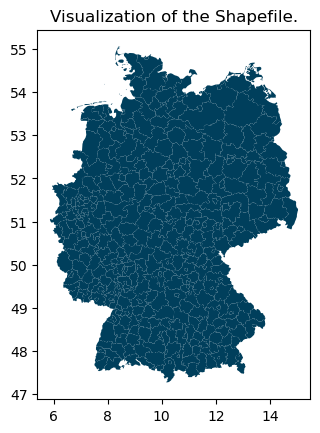

In [5]:
import geopandas as gpd
geo_df = gpd.read_file("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/vg2500_krs.shp")
geo2_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/GeoDf.csv")
geo_df = geo_df.set_geometry("geometry")  
geo_df.plot(color=colors[0])
plt.title("Visualization of the Shapefile.")
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
plt.savefig("ShapeFileVisualization.png")
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
plt.show()

In [49]:
renaming_dict = dict()
# Iterate over the names defined by the Shapefile
for name in geo_df.GEN.unique():
    renaming_dict[name] = []
    # then iterate over the locations names defined by the influenza.csv file
    for location in influenza_df.location.unique():
        # filter out the names, where the Shapefile-Name String is part of the Influenza-File-Name String, and save them to the dict
        if name in location:
            renaming_dict[name].append(location) 
    # overwrite some locations with manually defined matches
    if name in config.specific_matches.keys():
        renaming_dict[name] = config.specific_matches[name]
        
# save the entries of the renaming dict where we have no match or at least 2 matches
not_matching_dict = {k:v for k, v in zip(renaming_dict.keys(), renaming_dict.values()) if ((len(v)==0) | (len(v)>1))}
# also save the entries where we have exactly one match (as it's supposed to be)
correctly_matched_dict = {k:v for k, v in zip(renaming_dict.keys(), renaming_dict.values()) if len(v) == 1}

#remaining_loc = [location for location in locations if location not in [location[0] for location in correctly_matched_dict.values()]]
not_renamed_shapefile_locations = []

# Create the correct location column in the df
for name in renaming_dict.keys():
    # select not correctly matched locations 
    if name in not_matching_dict.keys():
        # select a subset containing the not correctly matched region 
        unmatched_df = geo_df[geo_df.GEN == name].copy()
        # locations with double entries "lK" and "SK" are correctly selected by their shape length
        if len(unmatched_df) > 1:
            unmatched_df.loc[unmatched_df["SHAPE_LENG"] == min(unmatched_df["SHAPE_LENG"]),"location"] = f"SK {name}"
            unmatched_df.loc[unmatched_df["SHAPE_LENG"] == max(unmatched_df["SHAPE_LENG"]),"location"] = f"LK {name}"
        # the remaining uncorrectly matched locations are given the Shapefile name and won't be considered further on [not_renamed_shapefile_locations]
        if len(unmatched_df) == 1:
            unmatched_df.loc[:,"location"] = f"{name}"
            not_renamed_shapefile_locations.append(name)
        # then the location column is inherited by the original df
        geo_df.loc[geo_df.GEN == name,"location"] = unmatched_df["location"]
    #select the names where we already have a correct match
    elif name in correctly_matched_dict.keys():
        geo_df.loc[geo_df["GEN"] == name,"location"] = correctly_matched_dict[name][0]
# Print out a message if there are still 
if geo_df["location"].isna().any() == True:
    print(f"THE DF contains nan locations.{geo_df[geo_df['location'].isna() == True]}")
    
    
    
    
    
matrix_df = pd.DataFrame(columns=config.berlin_neighbors.keys(), index=config.berlin_neighbors.keys())
for key in config.berlin_neighbors.keys():
    neighbors = config.berlin_neighbors[key]
    if len(neighbors) > 0:
        for neighbor in neighbors:
            matrix_df.loc[key, neighbor] = 1
            matrix_df.loc[neighbor, key] = 1
            matrix_df.loc[key, key] = 0
    else:
        print(key)
matrix_df = matrix_df.fillna(0)
#display(matrix_df)


geo_df["my_neighbors"] = ""
for index, row in geo_df.iterrows():  
    # determine the nieghboring regions and select their location name
    neighbors = list(geo_df[(geo_df.geometry.touches(row["geometry"])) | (geo_df.geometry.overlaps(row["geometry"]))].location)
    # remove the location itself, if it's within the determined neighbors
    if row.location in neighbors:   
        neighbors = neighbors.remove(row.location) 
    if neighbors is not None:
        geo_df.at[index, "my_neighbors"] = neighbors
geo_df["my_neighbors"] = geo_df["my_neighbors"].fillna("nan")

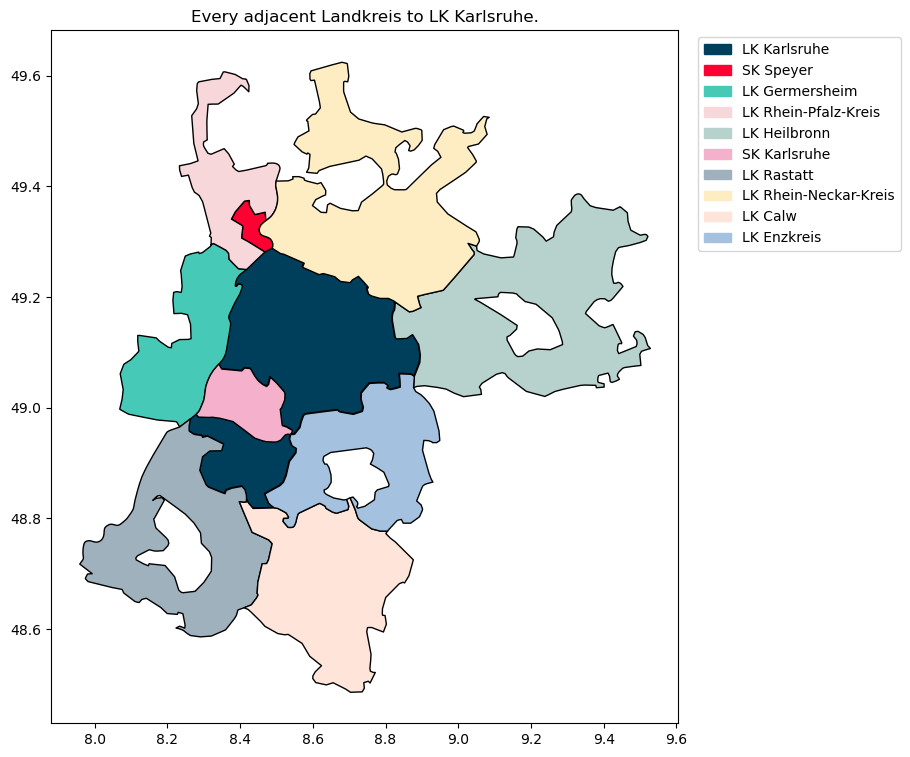

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

selection = ["LK Karlsruhe"]

for location in selection:
    location_df = geo_df.loc[geo_df.location == location].copy()
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    location_df.plot(ax=ax, label=location, color=colors[0], edgecolor='black')
    plt.title(f"Every adjacent Landkreis to {location}.")
    handles = [Patch(color='#003f5c', label=location)]  
    labels = [location]  
    neighbors = list(location_df["my_neighbors"])
    if len(neighbors) > 0:
        i = 1
        for neighbor in neighbors:
            neighbor_df = geo_df.loc[geo_df.location.isin(list(neighbor))].copy()
            for n in neighbor_df.location:
                neighbor_df[neighbor_df.location == n].plot(ax=ax, color=colors[i], legend=False, label=n, edgecolor='black')
                handles.append(Patch(color=colors[i], label=n))  
                labels.append(n)  
                i += 1 
    plt.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.subplots_adjust(right=0.85) 
    os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
    plt.savefig("NeighborsLKKarlsruhe.png")
    os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
    plt.show()

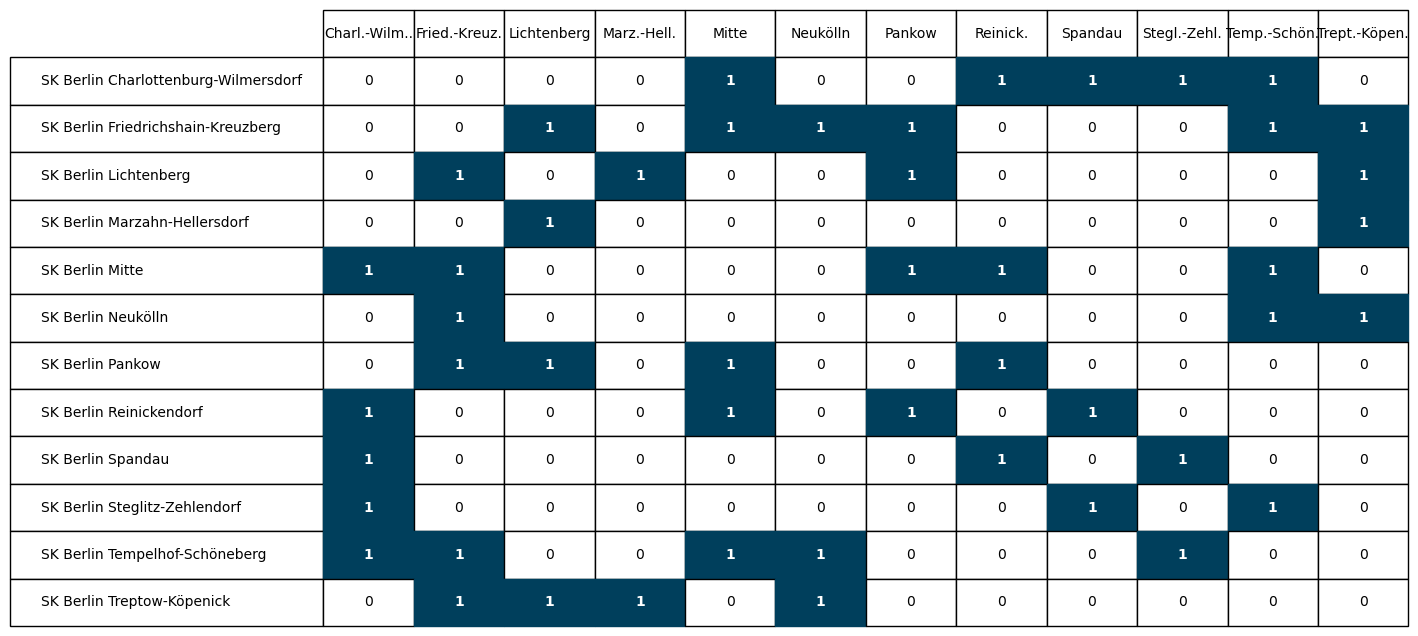

In [48]:
import matplotlib.pyplot as plt

berlin = [col for col in neighbourhood_df.columns if "Berlin" in col]
renamed = ["Charl.-Wilm..", "Fried.-Kreuz.", "Lichtenberg", "Marz.-Hell.", "Mitte", "Neukölln", "Pankow", "Reinick.", "Spandau", "Stegl.-Zehl.", "Temp.-Schön.", "Trept.-Köpen."]


plt.figure(figsize=(14, 8))  # Adjust the figure size as needed

ax = plt.subplot()
ax.axis('off')  # Remove axis visibility

table = ax.table(cellText=neighbourhood_df.loc[berlin, berlin].values,
                 rowLabels=neighbourhood_df.loc[berlin, berlin].index,
                 colLabels=renamed,
                 cellLoc='center',
                 loc='center',
                 bbox=(0, 0, 1, 1))  # Adjust the bbox as needed to fit the table within the figure

table.auto_set_font_size(False)
table.set_fontsize(10)  # Adjust the font size as needed

for cell in table.get_celld().values():
    if cell.get_text().get_text() == "1":
        # Check for "1" values
        cell.set_color(colors[0])
        cell.set_text_props(weight='bold', color='white')  # Set text color to white for "1" values
    #elif cell.get_text().get_text() == "0":  # Check for "0" values
     #   cell.set_color(colors[1])
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
plt.savefig('NeighbourhoodmatrixBerlinTable.png')
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
plt.show()

# Population display

In [9]:
# Data split with no additional features and training start in 2010
#data_splits_dict["without_features_2001"] = list(train_test_split(config, df, False))
data_splits_dict["with_features_2001"] = list(train_test_split(config, df, True))

# Change the beginning of the training period
#config.train_start_time = datetime(2010,1,1,0,0,0)
#data_splits_dict["without_features_2010"] = list(train_test_split(config, df, False))
#data_splits_dict["with_features_2010"] = list(train_test_split(config, df, True))